# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 20      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7480.22705078125
iteration 0 loss 2.0235888910758052e+18


iteration 5000 loss 2203993767936.0


iteration 10000 loss 147375063040.0


iteration 15000 loss 10788982784.0


iteration 20000 loss 780664704.0


iteration 25000 loss 52274284.0


iteration 30000 loss 2513869.25


iteration 35000 loss 18971.142578125


iteration 40000 loss 393.1912536621094


iteration 45000 loss 28.731399536132812


iteration 50000 loss 3.639098644256592


iteration 55000 loss 1.7706422805786133


iteration 60000 loss 0.9920133352279663


iteration 65000 loss 1.8486456871032715


iteration 70000 loss 1.6920976638793945


iteration 75000 loss 1.6164723634719849


iteration 80000 loss 1.5209466218948364


iteration 85000 loss 0.6506045460700989


iteration 90000 loss 0.4278280735015869


iteration 95000 loss 0.3781609535217285


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.33917006850242615


iteration 105000 loss 0.017408277839422226


iteration 110000 loss 0.008212282322347164


iteration 115000 loss 0.0051243118941783905


iteration 120000 loss 0.003318486036732793


iteration 125000 loss 0.0026361350901424885


iteration 130000 loss 0.0015706396661698818


iteration 135000 loss 0.001120682922191918


iteration 140000 loss 0.0008518699323758483


iteration 145000 loss 0.0005612575332634151


iteration 150000 loss 0.00041840533958747983


iteration 155000 loss 0.0003153648867737502


iteration 160000 loss 0.00023821434297133237


iteration 165000 loss 0.00020562139980029315


iteration 170000 loss 0.00017297506565228105


iteration 175000 loss 0.2852931022644043


iteration 180000 loss 9.559789032209665e-05


iteration 185000 loss 9.152624988928437e-05


iteration 190000 loss 6.692256283713505e-05


iteration 195000 loss 5.807238630950451e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 4.969681322108954e-05


iteration 205000 loss 3.397778345970437e-05


iteration 210000 loss 2.2419460947276093e-05


iteration 215000 loss 1.5325125787057914e-05


iteration 220000 loss 1.0850713806576096e-05


iteration 225000 loss 8.158423952409066e-06


iteration 230000 loss 5.854624305356992e-06


iteration 235000 loss 4.208980044495547e-06


iteration 240000 loss 3.338116584927775e-06


iteration 245000 loss 2.5271697268181015e-06


iteration 250000 loss 1.8924718006019248e-06


iteration 255000 loss 1.4497918527922593e-06


iteration 260000 loss 1.1841577816085191e-06


iteration 265000 loss 1.0053413461719174e-06


iteration 270000 loss 7.631874723301735e-07


iteration 275000 loss 5.721955176340998e-07


iteration 280000 loss 5.464987111736264e-07


iteration 285000 loss 4.989443027625384e-07


iteration 290000 loss 3.1260324817594665e-07


iteration 295000 loss 5.330997510100133e-07


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 2.40292024500377e-07


iteration 305000 loss 1.889432894586207e-07


iteration 310000 loss 1.4955038807329402e-07


iteration 315000 loss 1.6354960052922252e-07


iteration 320000 loss 1.0495572411173271e-07


iteration 325000 loss 9.270159750940365e-08


iteration 330000 loss 8.410949448034444e-08


iteration 335000 loss 7.136019775089153e-08


iteration 340000 loss 6.582408218491764e-08


iteration 345000 loss 5.547975590047827e-08


iteration 350000 loss 5.161623661820158e-08


iteration 355000 loss 4.156828708801186e-06


iteration 360000 loss 4.16183425500094e-08


iteration 365000 loss 3.9128170925550876e-08


iteration 370000 loss 3.35204610735218e-08


iteration 375000 loss 3.241365220674197e-08


iteration 380000 loss 5.7547591580942026e-08


iteration 385000 loss 2.7125496515623126e-08


iteration 390000 loss 2.6841844302794016e-08


iteration 395000 loss 2.2716546865808596e-08


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.3114550273817258e-08


iteration 405000 loss 2.1295990748626537e-08


iteration 410000 loss 1.9073318924256455e-08


iteration 415000 loss 1.7732860513319793e-08


iteration 420000 loss 1.6795544510728178e-08


iteration 425000 loss 1.5681131060318876e-08


iteration 430000 loss 1.491228474037598e-08


iteration 435000 loss 1.4217092392243558e-08


iteration 440000 loss 1.3454135583401694e-08


iteration 445000 loss 1.3028867762443497e-08


iteration 450000 loss 1.2189395270922887e-08


iteration 455000 loss 1.1646889674921113e-08


iteration 460000 loss 1.1159220214551624e-08


iteration 465000 loss 1.0596014732300318e-08


iteration 470000 loss 1.0249877391288464e-08


iteration 475000 loss 9.735729555870876e-09


iteration 480000 loss 9.331422745617601e-09


iteration 485000 loss 8.934762263379525e-09


iteration 490000 loss 8.52495141145937e-09


iteration 495000 loss 8.275923946143848e-09


L2 loss -- Plot

loss -1687.791259765625


loss -2726.67333984375


loss -2971.0205078125


loss -3028.816162109375


loss -3054.10107421875


loss -3069.2099609375


loss -3078.62353515625


loss -3084.864013671875


loss -3088.4501953125


loss -3089.78271484375


loss -3090.14501953125


loss -3090.26220703125


loss -3090.294921875


loss -3090.307373046875


loss -3090.314208984375


loss -3090.31689453125


loss -3090.3193359375


loss -3090.3203125


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.3203125


loss -3090.3203125


loss -3090.3203125


loss -3090.3203125


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.320556640625


loss -3090.32080078125


loss -3090.32080078125


loss -3090.3203125


loss -3090.3203125


loss -3090.3203125


loss -3090.3203125


final mse:  9.414828127773944e-06
max, min: 2.3168104 -3.5246742
loss -1687.791259765625


loss -2770.99462890625


loss -3021.33251953125


loss -3082.21044921875


loss -3107.42333984375


loss -3123.3115234375


loss -3133.772705078125


loss -3140.8779296875


loss -3144.55419921875


loss -3146.28955078125


loss -3147.10986328125


loss -3147.49169921875


loss -3147.64990234375


loss -3147.7109375


loss -3147.731201171875


loss -3147.736328125


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.737060546875


loss -3147.737060546875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.7373046875


loss -3147.737060546875


loss -3147.7373046875


loss -3147.737060546875


loss -3147.7373046875


loss -3147.7373046875


final mse:  8.991343747766223e-06
max, min: 3.539005 -3.914927


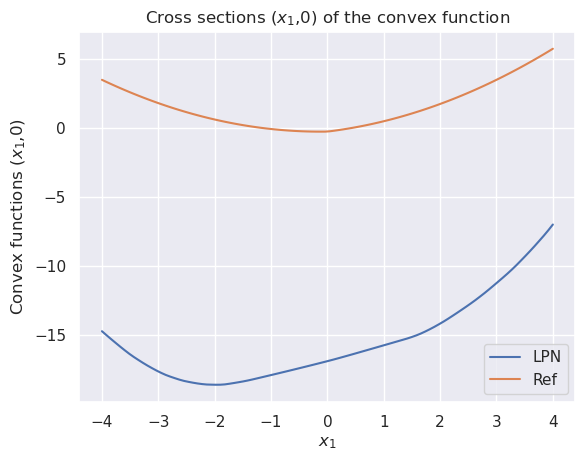

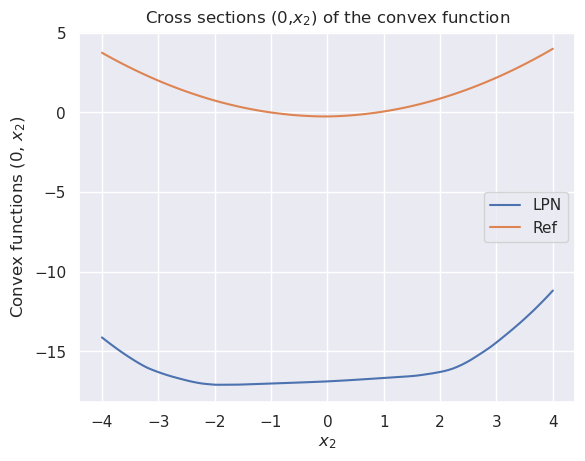

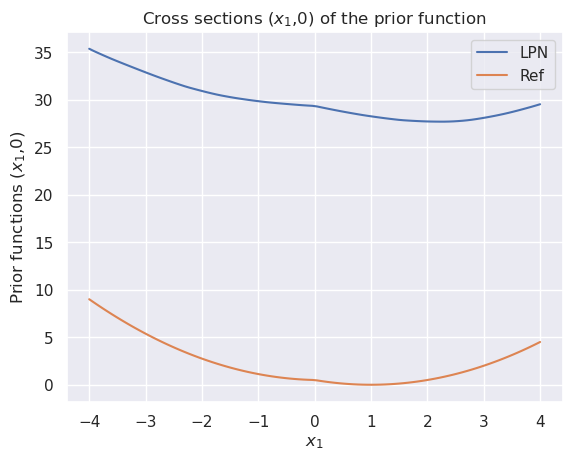

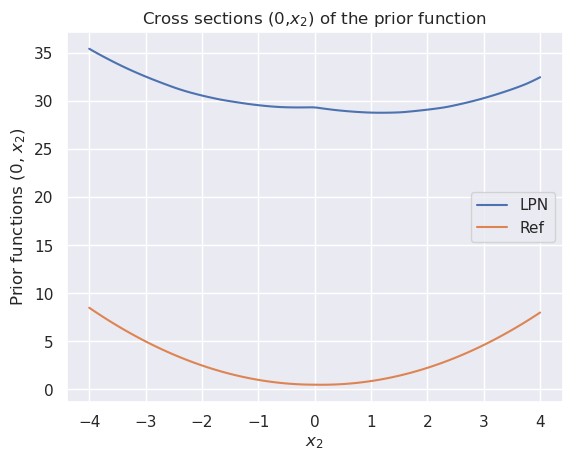

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 9867.744140625
iteration 0 loss 7.486740974660485e+17


iteration 5000 loss 812811485184.0


iteration 10000 loss 54183596032.0


iteration 15000 loss 3933837568.0


iteration 20000 loss 276697824.0


iteration 25000 loss 16743564.0


iteration 30000 loss 451289.0625


iteration 35000 loss 7574.51025390625


iteration 40000 loss 532.5904541015625


iteration 45000 loss 46.7127685546875


iteration 50000 loss 5.674400329589844


iteration 55000 loss 0.824565589427948


iteration 60000 loss 0.39153555035591125


iteration 65000 loss 0.3111574053764343


iteration 70000 loss 0.32812371850013733


iteration 75000 loss 1.8083542585372925


iteration 80000 loss 0.5249677896499634


iteration 85000 loss 0.8412157297134399


iteration 90000 loss 0.7668394446372986


iteration 95000 loss 0.6783243417739868


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.6261923909187317


iteration 105000 loss 0.0383869893848896


iteration 110000 loss 0.026038359850645065


iteration 115000 loss 0.019434185698628426


iteration 120000 loss 0.014802981168031693


iteration 125000 loss 0.07415545731782913


iteration 130000 loss 0.008793945424258709


iteration 135000 loss 0.0068391477689146996


iteration 140000 loss 0.005441265180706978


iteration 145000 loss 0.004471038933843374


iteration 150000 loss 0.0037316549569368362


iteration 155000 loss 0.003069923724979162


iteration 160000 loss 0.0025012632831931114


iteration 165000 loss 0.0020231856033205986


iteration 170000 loss 0.0018088237848132849


iteration 175000 loss 0.00142859504558146


iteration 180000 loss 0.0013249559560790658


iteration 185000 loss 0.001016137539409101


iteration 190000 loss 0.0009383481810800731


iteration 195000 loss 0.000987091800197959


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0006764702848158777


iteration 205000 loss 0.000591192627325654


iteration 210000 loss 0.00048300789785571396


iteration 215000 loss 0.0003987126110587269


iteration 220000 loss 0.000328595022438094


iteration 225000 loss 0.0002738517941907048


iteration 230000 loss 0.00022995338076725602


iteration 235000 loss 0.00019252208585385233


iteration 240000 loss 0.00016181074897758663


iteration 245000 loss 0.00013543352542910725


iteration 250000 loss 0.00011644201003946364


iteration 255000 loss 9.86827362794429e-05


iteration 260000 loss 8.324416558025405e-05


iteration 265000 loss 7.140999514376745e-05


iteration 270000 loss 6.187545659486204e-05


iteration 275000 loss 5.215580313233659e-05


iteration 280000 loss 4.448348772712052e-05


iteration 285000 loss 3.850846042041667e-05


iteration 290000 loss 3.364304211572744e-05


iteration 295000 loss 2.9473872928065248e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.008796482346951962


iteration 305000 loss 2.4481072614435107e-05


iteration 310000 loss 2.1025713067501783e-05


iteration 315000 loss 1.8166470908909105e-05


iteration 320000 loss 1.569497908349149e-05


iteration 325000 loss 1.3760884939983953e-05


iteration 330000 loss 1.2066246199538e-05


iteration 335000 loss 1.0622437002894003e-05


iteration 340000 loss 9.285440683015622e-06


iteration 345000 loss 8.149143468472175e-06


iteration 350000 loss 7.169192940637004e-06


iteration 355000 loss 6.414605650206795e-06


iteration 360000 loss 5.6460548876202665e-06


iteration 365000 loss 5.008022526453715e-06


iteration 370000 loss 4.437672032508999e-06


iteration 375000 loss 3.953904524678364e-06


iteration 380000 loss 3.5391069559409516e-06


iteration 385000 loss 3.2054156235972187e-06


iteration 390000 loss 2.8910203582199756e-06


iteration 395000 loss 2.613648803162505e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.368688910792116e-06


iteration 405000 loss 2.269849574076943e-06


iteration 410000 loss 2.059412736343802e-06


iteration 415000 loss 1.8967905361932935e-06


iteration 420000 loss 1.7357244814775186e-06


iteration 425000 loss 1.6066619537014049e-06


iteration 430000 loss 1.4752940842299722e-06


iteration 435000 loss 1.4601093880628468e-06


iteration 440000 loss 1.2691192523561767e-06


iteration 445000 loss 1.1699549986587954e-06


iteration 450000 loss 1.0881145726671093e-06


iteration 455000 loss 1.0125895641976967e-06


iteration 460000 loss 9.442880468668591e-07


iteration 465000 loss 8.819305890028772e-07


iteration 470000 loss 8.253825853898888e-07


iteration 475000 loss 7.714942853453977e-07


iteration 480000 loss 7.238125476760615e-07


iteration 485000 loss 6.801829499636369e-07


iteration 490000 loss 6.374246481755108e-07


iteration 495000 loss 6.006846433592727e-07


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


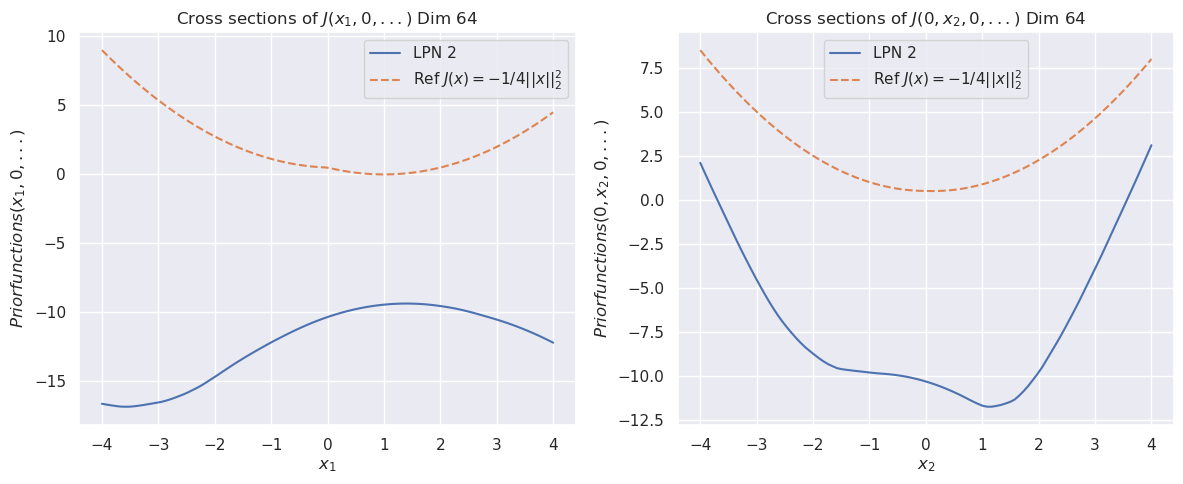

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)